In [4]:
!pip install rasterstats

   ---------------------------------------- 0.0/25.4 MB ? eta -:--:--
   - -------------------------------------- 1.0/25.4 MB 6.2 MB/s eta 0:00:04
   ----- ---------------------------------- 3.4/25.4 MB 9.1 MB/s eta 0:00:03
   --------- ------------------------------ 6.0/25.4 MB 10.5 MB/s eta 0:00:02
   ----------- ---------------------------- 7.6/25.4 MB 9.7 MB/s eta 0:00:02
   -------------- ------------------------- 8.9/25.4 MB 9.1 MB/s eta 0:00:02
   ---------------- ----------------------- 10.7/25.4 MB 9.1 MB/s eta 0:00:02
   ------------------ --------------------- 12.1/25.4 MB 8.6 MB/s eta 0:00:02
   --------------------- ------------------ 13.6/25.4 MB 8.5 MB/s eta 0:00:02
   ----------------------- ---------------- 15.2/25.4 MB 8.4 MB/s eta 0:00:02
   ------------------------- -------------- 16.3/25.4 MB 8.2 MB/s eta 0:00:02
   ---------------------------- ----------- 17.8/25.4 MB 8.1 MB/s eta 0:00:01
   ------------------------------ --------- 19.7/25.4 MB 8.1 MB/s eta 0:00:0

In [1]:
import geopandas as gpd
import rasterio, rasterio.mask
from rasterstats import zonal_stats
import pandas as pd

legend = {
 1: "1. Formación Forestal",
 3: "1.1. Bosque",
 4: "1.2. Bosque abierto",
 5: "1.3. Manglar",
 6: "1.4. Bosque inundable",
 10: "2. Formación natural no forestal",
 11: "2.1. Formación natural no forestal inundable",
 12: "2.2. Herbazal",
 29: "2.3. Afloramiento rocoso",
 13: "2.4. Otra formación natural no forestal",
 14: "3. Agropecuaria y silvicultura",
 9: "3.3 Silvicultura",
 21: "3.5 Mosaico de agricultura y/o pastos",
 22: "4. Área sin vegetación",
 23: "4.1. Playa, duna o banco de arena",
 24: "4.2. Infraestructura urbana",
 30: "4.3. Minería",
 68: "4.4. Otra área natural sin vegetación",
 25: "4.5. Otra área antrópica sin vegetación",
 26: "5. Cuerpo de agua",
 33: "5.1 Río, lago u océano",
 34: "5.2 Glaciar",
 31: "5.3 Acuicultura",
 27: "6. No observado"
}

basins = gpd.read_file(r"C:\Users\carsk\OneDrive - UNIR\Ecociencia\Poblacion\Resultados\Poblacion\Poblacion_1\hybas6_7ECclip.gpkg")
with rasterio.open(r"C:\Users\carsk\Downloads\mapbiomas-ecuador-collection-20-2023.tif") as src:
    raster_crs = src.crs
basins = basins.to_crs(raster_crs)
mask_geom = [basins.unary_union]

def mask_raster(in_path, out_path, mask_geom):
    with rasterio.open(in_path) as src:
        out_img, out_trans = rasterio.mask.mask(src, mask_geom, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({"height": out_img.shape[1],
                         "width": out_img.shape[2],
                         "transform": out_trans})
    with rasterio.open(out_path, "w", **out_meta) as dest:
        dest.write(out_img)

mask_raster(r"C:\Users\carsk\Downloads\mapbiomas-ecuador-collection-20-2023.tif",
            r"C:\Users\carsk\Downloads\masked_2023.tif", mask_geom)
mask_raster(r"C:\Users\carsk\Downloads\ecuador_coverage_2005.tif",
            r"C:\Users\carsk\Downloads\masked_2004.tif", mask_geom)

stats2023 = zonal_stats(basins, r"C:\Users\carsk\Downloads\masked_2023.tif", categorical=True)
stats2004 = zonal_stats(basins, r"C:\Users\carsk\Downloads\masked_2004.tif", categorical=True)

rows = []
for i, basin in basins.iterrows():
    tot2023 = sum(stats2023[i].values())
    tot2004 = sum(stats2004[i].values())
    basin_rows = []
    classes = set(stats2023[i].keys()).union(stats2004[i].keys())
    for cl in classes:
        cnt2023 = stats2023[i].get(cl, 0)
        cnt2004 = stats2004[i].get(cl, 0)
        basin_rows.append({
            "HYBAS_ID": basin["HYBAS_ID"],
            "pixel_id": cl,
            "clase_de_cobertura": legend.get(int(cl), f"Desconocido {cl}"),
            "pct_2023": (cnt2023 / tot2023) * 100 if tot2023 else 0,
            "pct_2004": (cnt2004 / tot2004) * 100 if tot2004 else 0
        })
    basin_rows.sort(key=lambda x: x["pct_2023"], reverse=True)
    rows.extend(basin_rows)

pd.DataFrame(rows).to_csv(r"C:\Users\carsk\Downloads\landcover_percentage.csv", index=False)


C:\Users\carsk\AppData\Local\Temp\ipykernel_13184\3583164970.py:37: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mask_geom = [basins.unary_union]
c:\Users\carsk\miniforge3\envs\ECOCIENCIA\Lib\site-packages\rasterstats\io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


Most changed land cover class:
clase_de_cobertura    3.5 Mosaico de agricultura y/o pastos
change_pct                                        24.903041
Name: 8, dtype: object


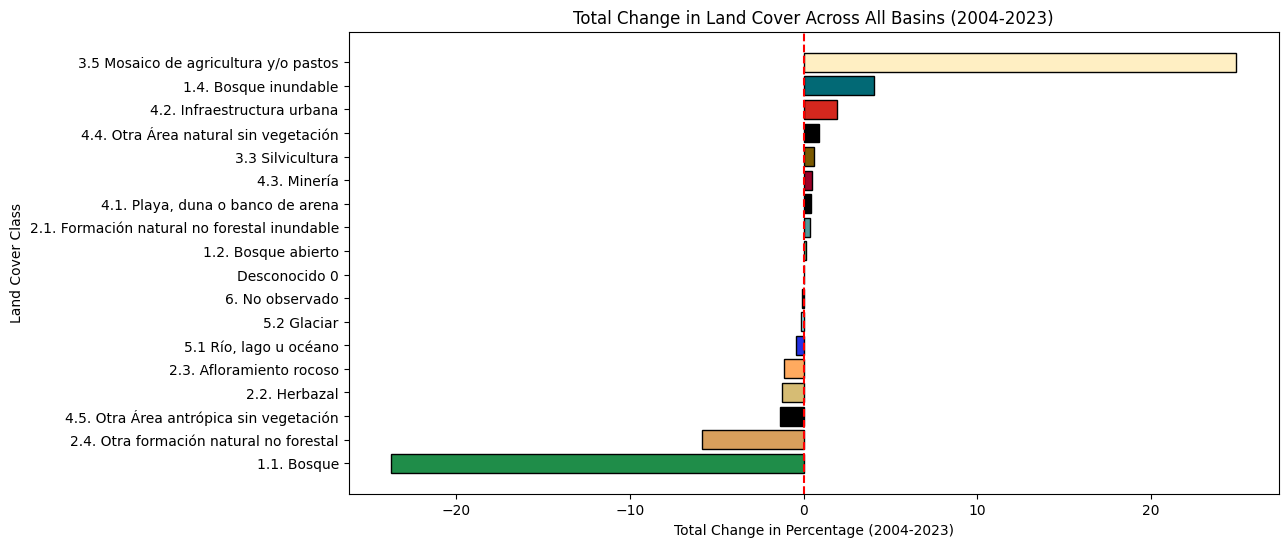

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# File path (update if needed)
file_path = r"C:\Users\carsk\Downloads\landcover_percentage.csv"

# Load the dataset
df = pd.read_csv(file_path, encoding="latin1")

# Define color mapping for land cover classes
color_map = {
    "1.1. Bosque": "#1f8d49",
    "1.2. Bosque abierto": "#7dc975",
    "1.3. Manglar": "#04381d",
    "1.4. Bosque inundable": "#026975",
    "2.2. Herbazal": "#d6bc74",
    "2.1. Formación natural no forestal inundable": "#519799",
    "2.3. Afloramiento rocoso": "#ffaa5f",
    "2.4. Otra formación natural no forestal": "#d89f5c",
    "3.3 Silvicultura": "#7a5900",
    "3.5 Mosaico de agricultura y/o pastos": "#ffefc3",
    "4.2. Infraestructura urbana": "#d4271e",
    "4.3. Minería": "#9c0027",
    "4.4. Otra área natural sin vegetación": "#e97a7a",
    "4.5. Otra área antrópica sin vegetación": "#db4d4f",
    "5.1 Río, lago u océano": "#2532e4",
    "5.2 Glaciar": "#93dfe6",
    "5.3 Acuicultura": "#091077"
}
# Calculate the change in land cover percentage between 2004 and 2023
df["change_pct"] = df["pct_2023"] - df["pct_2004"]

# Summarize total change by land cover class
overall_landcover_changes = df.groupby("clase_de_cobertura")["change_pct"].sum().reset_index()
overall_landcover_changes = overall_landcover_changes.sort_values(by="change_pct", ascending=False)

# Identify the land use with the highest net change
top_changing_landcover = overall_landcover_changes.iloc[0]
print("Most changed land cover class:")
print(top_changing_landcover)

# Create a bar plot to visualize overall change per land cover class
plt.figure(figsize=(12, 6))
colors = [color_map.get(lc, "#000000") for lc in overall_landcover_changes["clase_de_cobertura"]]
plt.barh(overall_landcover_changes["clase_de_cobertura"], overall_landcover_changes["change_pct"], color=colors, edgecolor='black')
plt.xlabel("Total Change in Percentage (2004-2023)")
plt.ylabel("Land Cover Class")
plt.title("Total Change in Land Cover Across All Basins (2004-2023)")
plt.axvline(0, color='red', linestyle='--')  # Reference line for zero change
plt.gca().invert_yaxis()
plt.show()

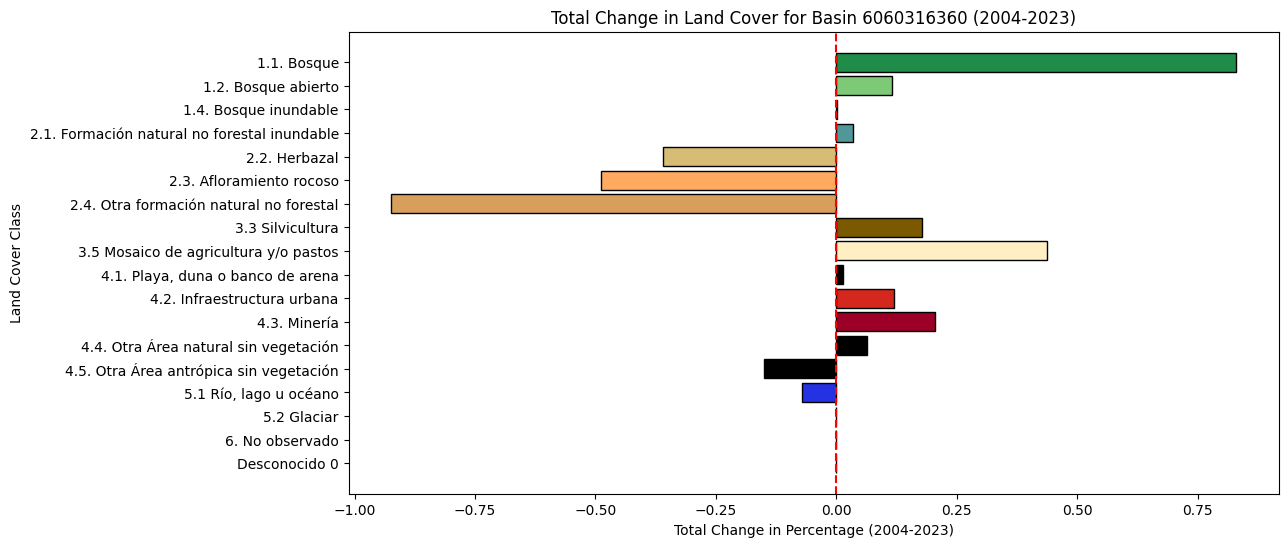

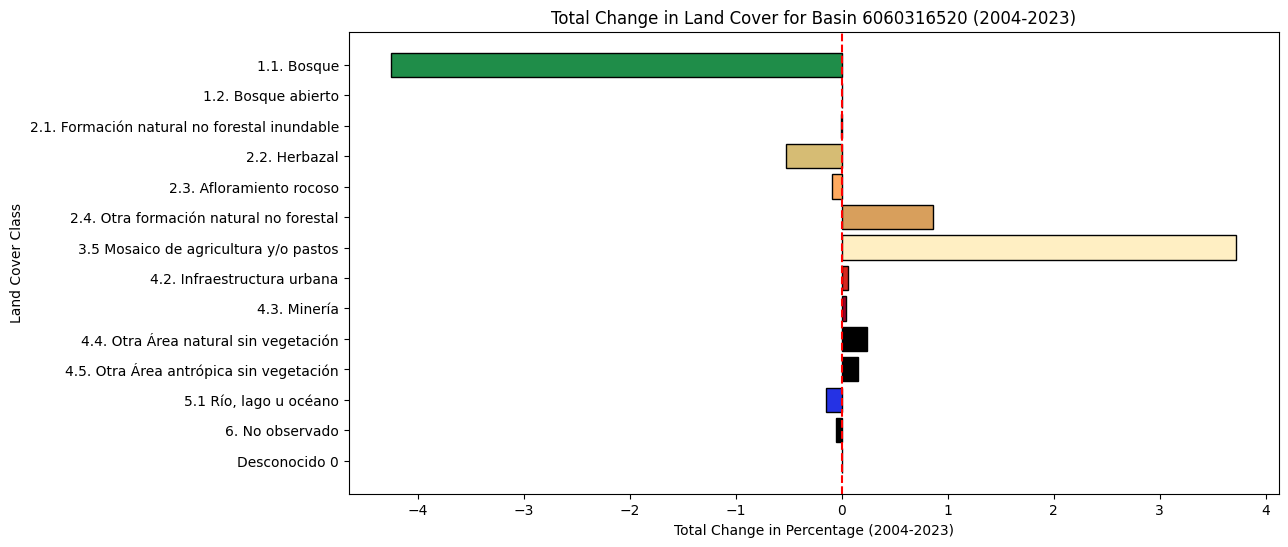

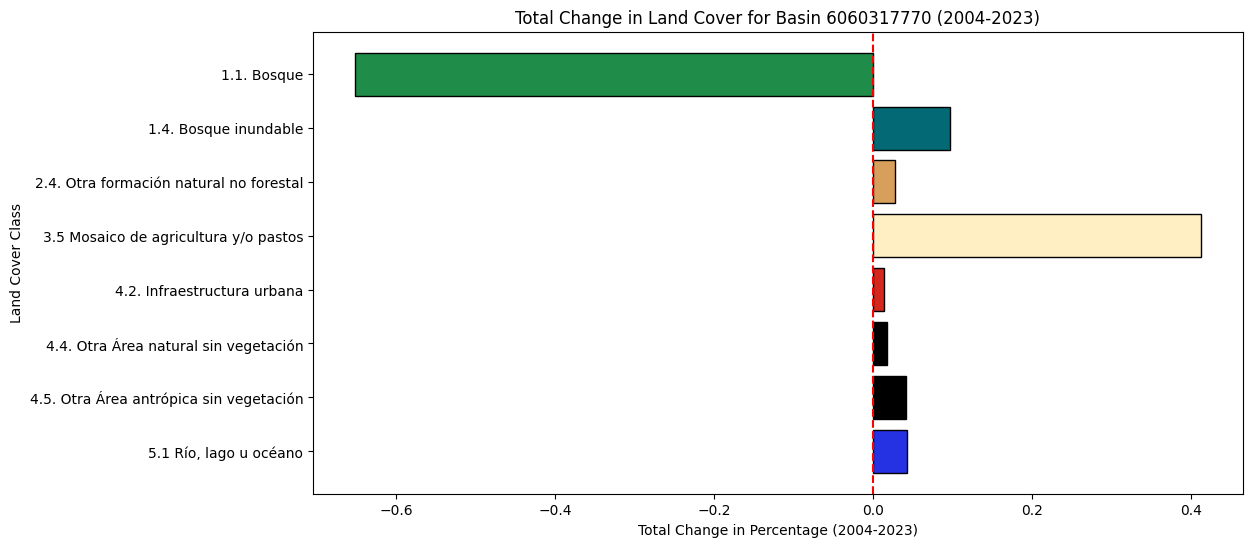

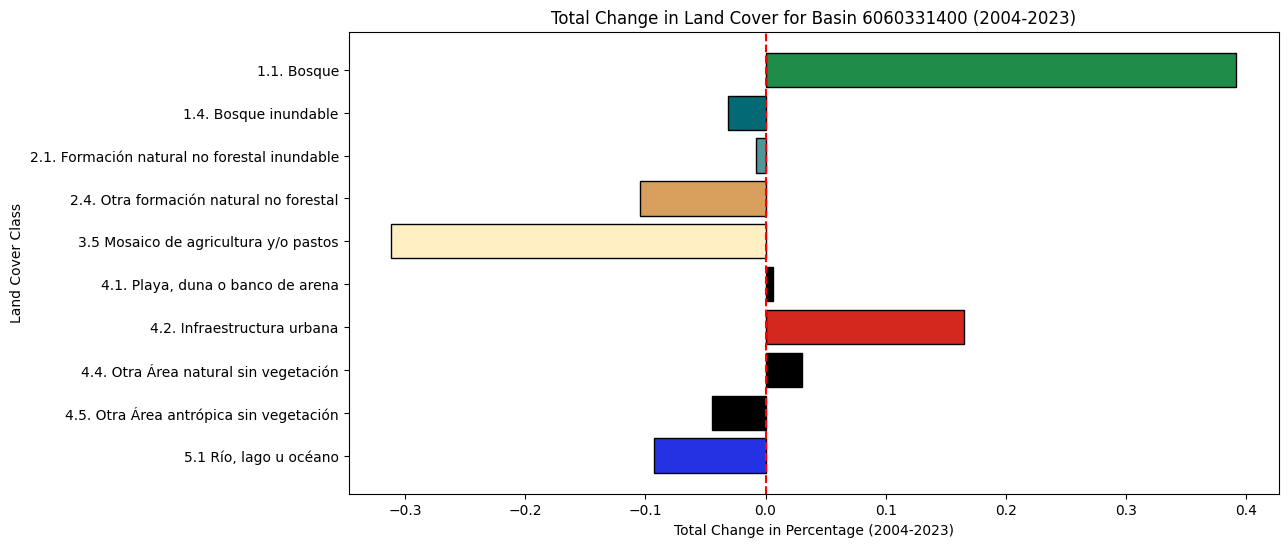

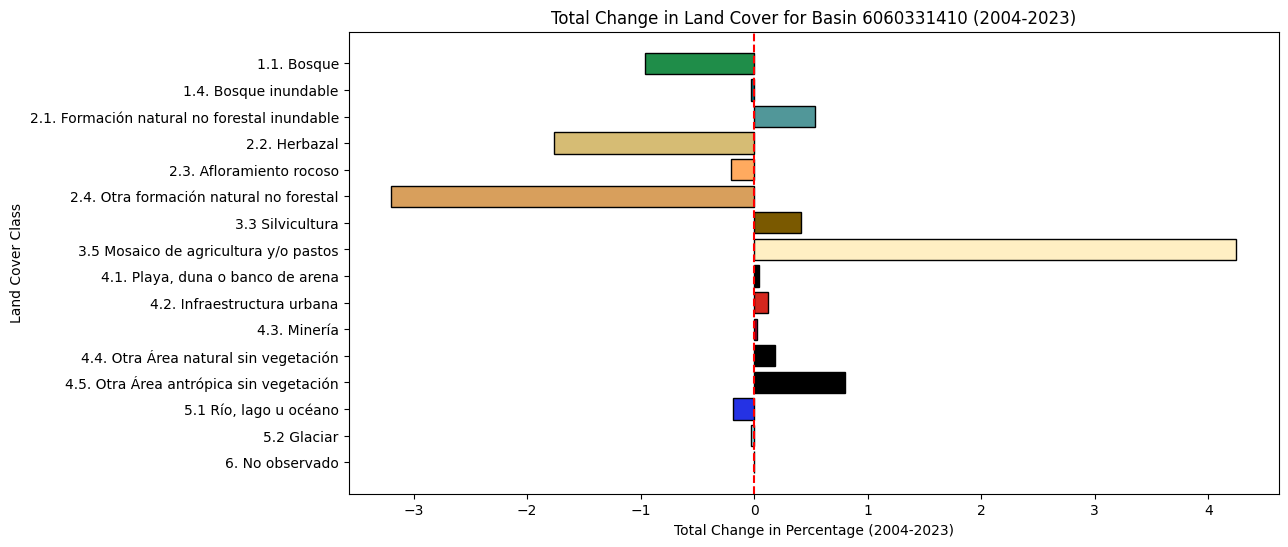

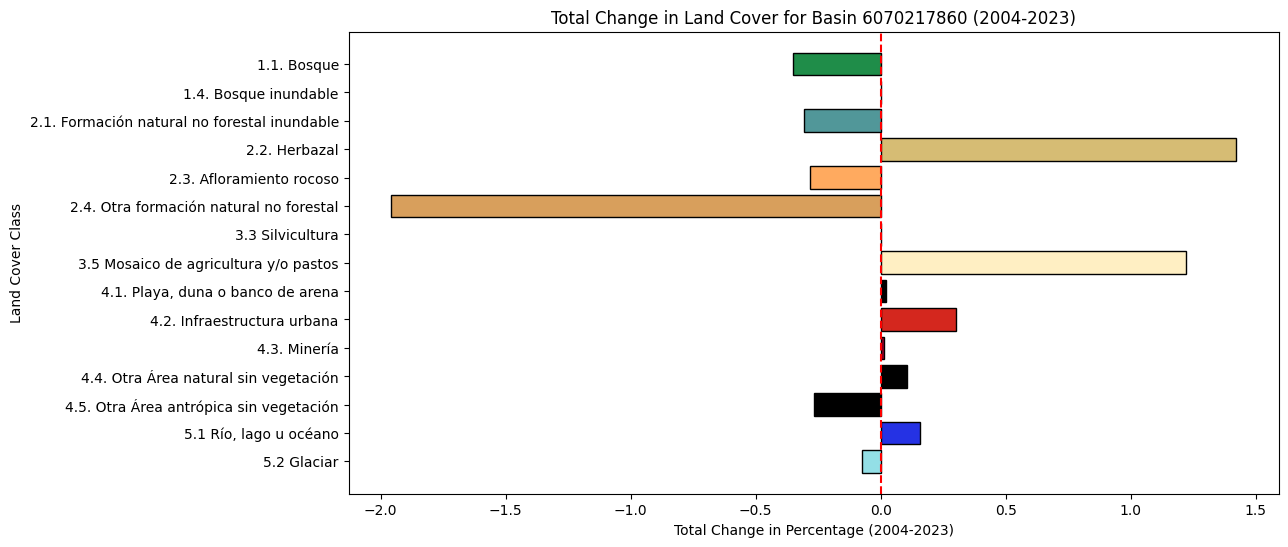

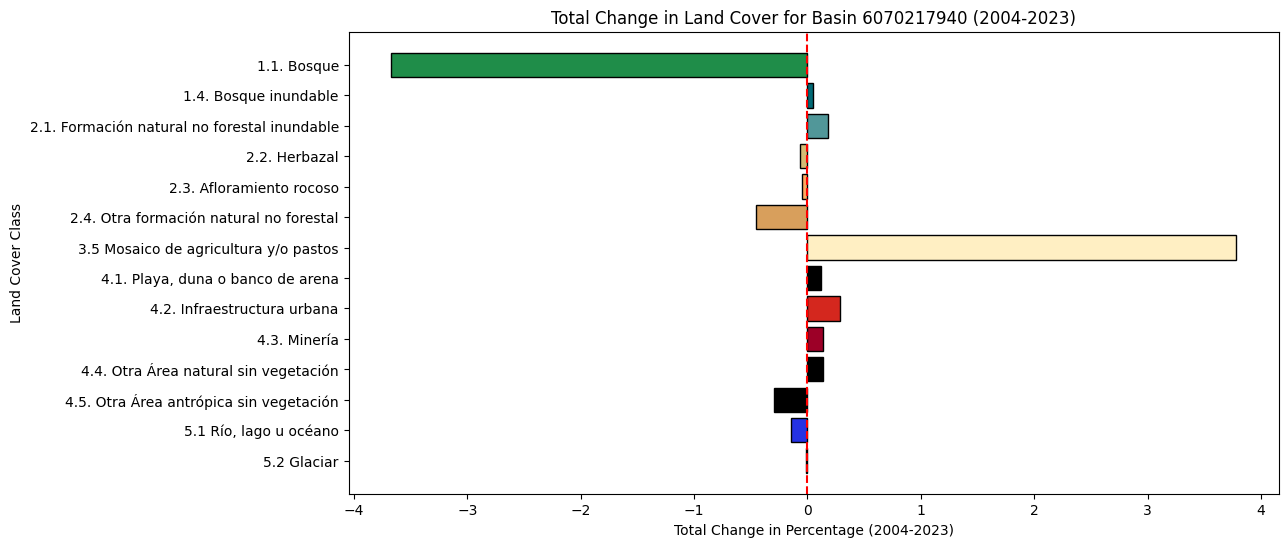

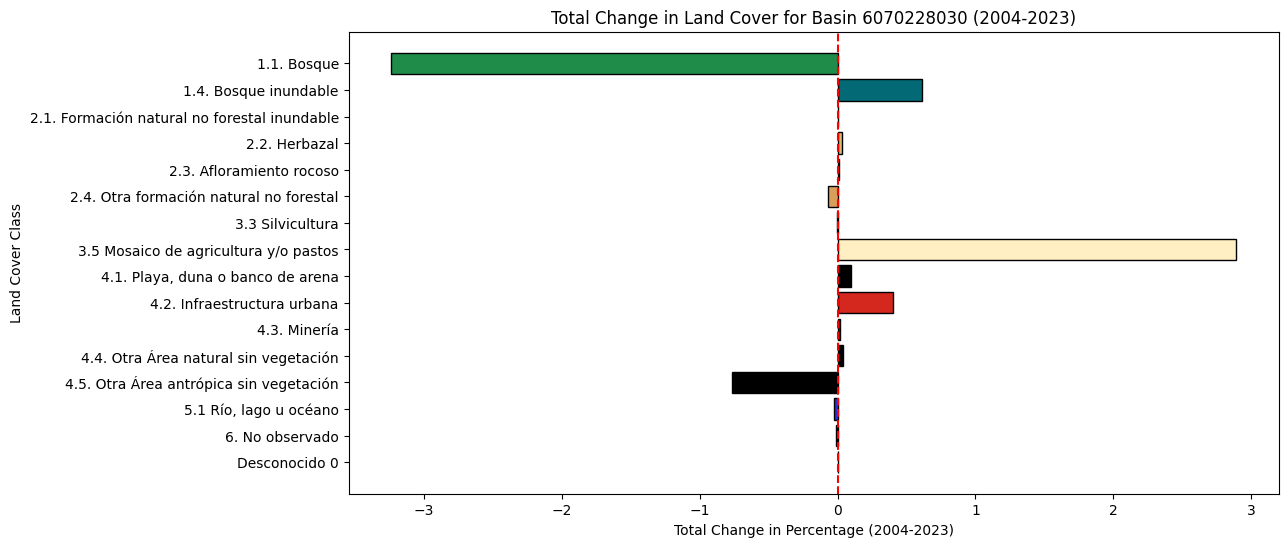

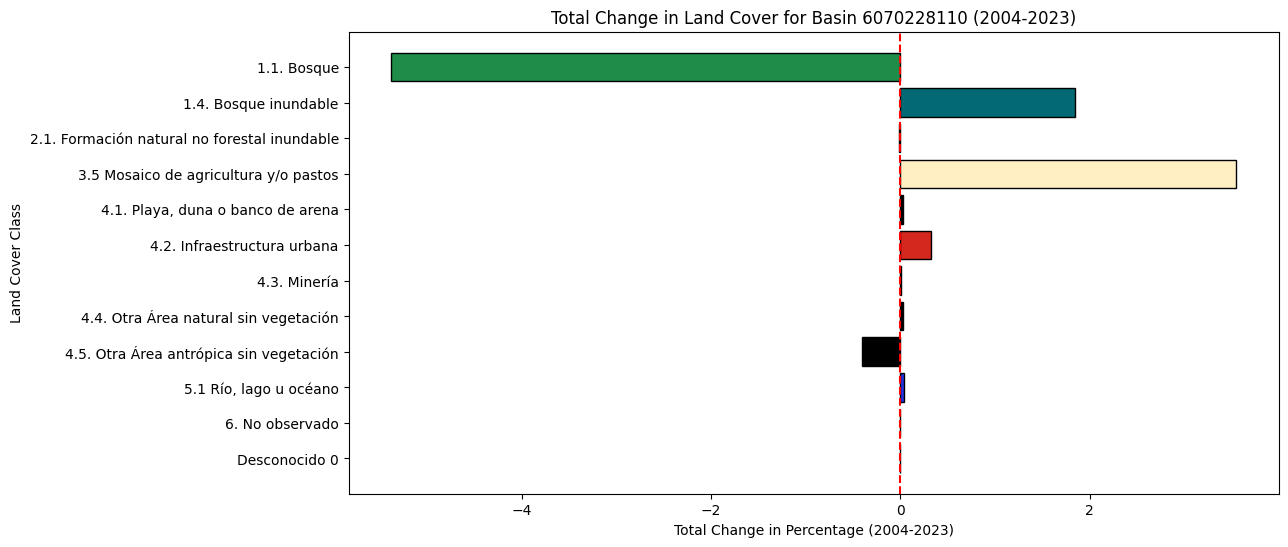

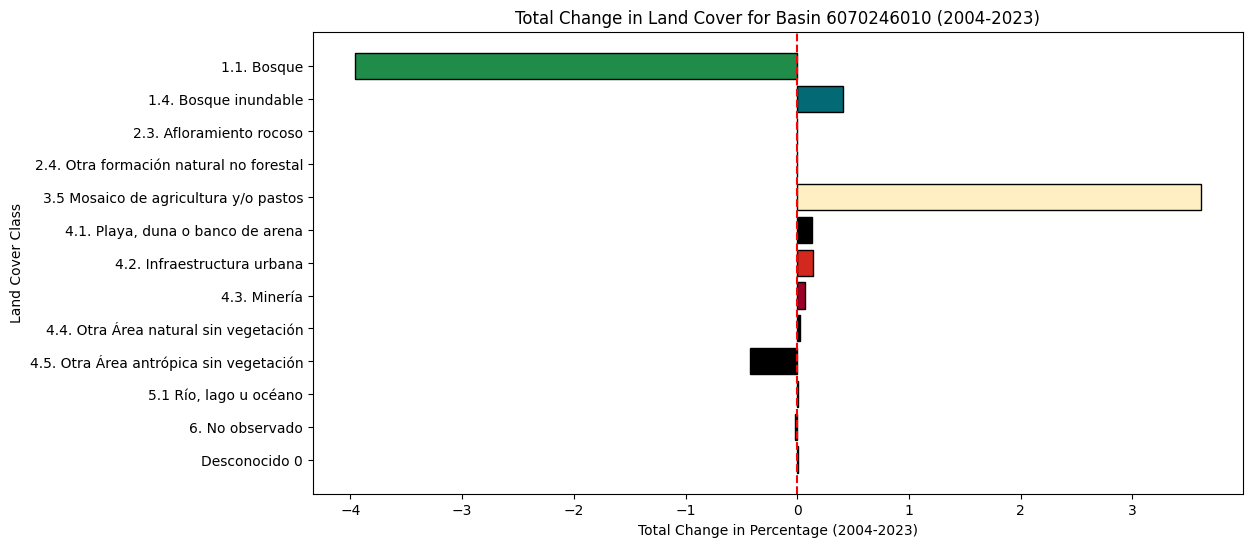

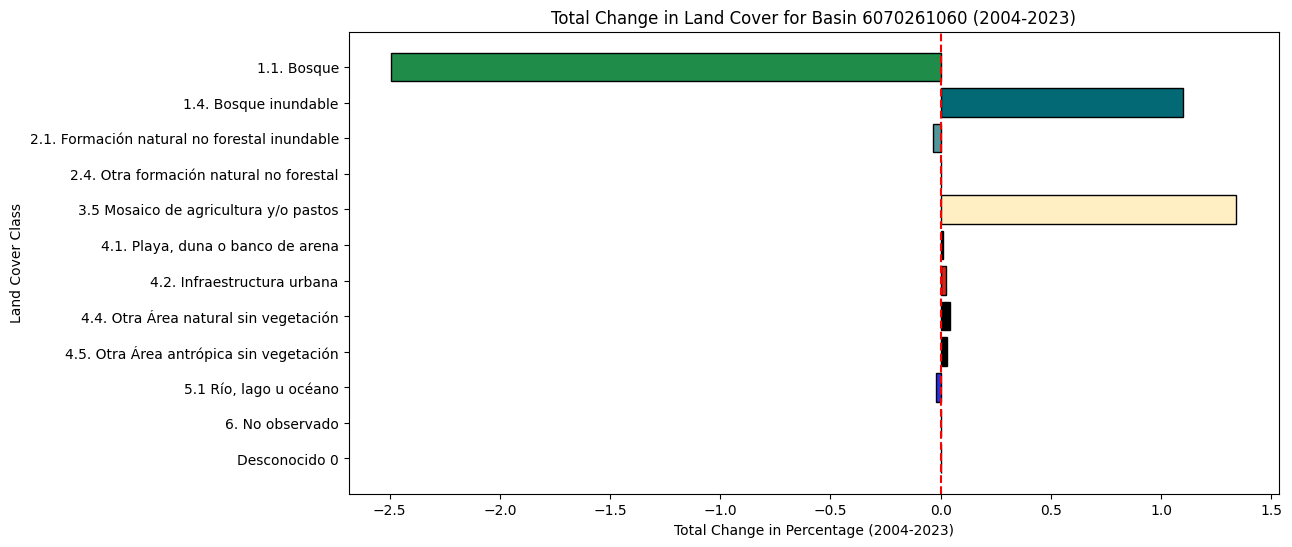

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# File path (update if needed)
file_path = r"C:\Users\carsk\Downloads\landcover_percentage.csv"

# Load the dataset
df = pd.read_csv(file_path, encoding="latin1")

# Define color mapping for land cover classes
color_map = {
    "1.1. Bosque": "#1f8d49",
    "1.2. Bosque abierto": "#7dc975",
    "1.3. Manglar": "#04381d",
    "1.4. Bosque inundable": "#026975",
    "2.2. Herbazal": "#d6bc74",
    "2.1. Formación natural no forestal inundable": "#519799",
    "2.3. Afloramiento rocoso": "#ffaa5f",
    "2.4. Otra formación natural no forestal": "#d89f5c",
    "3.3 Silvicultura": "#7a5900",
    "3.5 Mosaico de agricultura y/o pastos": "#ffefc3",
    "4.2. Infraestructura urbana": "#d4271e",
    "4.3. Minería": "#9c0027",
    "4.4. Otra área natural sin vegetación": "#e97a7a",
    "4.5. Otra área antrópica sin vegetación": "#db4d4f",
    "5.1 Río, lago u océano": "#2532e4",
    "5.2 Glaciar": "#93dfe6",
    "5.3 Acuicultura": "#091077"
}

# Calculate the change in land cover percentage between 2004 and 2023
df["change_pct"] = df["pct_2023"] - df["pct_2004"]

# Summarize total change by basin and land cover class
basin_landcover_changes = df.groupby(["HYBAS_ID", "clase_de_cobertura"])["change_pct"].sum().reset_index()

# Generate plots for each basin
for basin_id, basin_data in basin_landcover_changes.groupby("HYBAS_ID"):
    plt.figure(figsize=(12, 6))
    colors = [color_map.get(lc, "#000000") for lc in basin_data["clase_de_cobertura"]]
    plt.barh(basin_data["clase_de_cobertura"], basin_data["change_pct"], color=colors, edgecolor='black')
    plt.xlabel("Total Change in Percentage (2004-2023)")
    plt.ylabel("Land Cover Class")
    plt.title(f"Total Change in Land Cover for Basin {basin_id} (2004-2023)")
    plt.axvline(0, color='red', linestyle='--')  # Reference line for zero change
    plt.gca().invert_yaxis()
    plt.show()
